In [4]:
!pip install scipy==1.2.0
!pip install pmdarima
!pip install tbats
!pip install python-geohash
!pip install catboost 
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

path = "drive/My Drive/training.csv"
dataset = pd.read_csv(path)
# read from file option
#dataset = pd.read_csv('/content/training.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import print_function
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import mean_squared_error
# ignore all future warnings 
#simplefilter(action='ignore', category=FutureWarning) #hide https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/
from warnings import filterwarnings
filterwarnings('ignore') #https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn

from datetime import timedelta  
from datetime import datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
# mapping
import folium
from folium import plugins
import geohash

# models
from statsmodels.tsa.arima_model import ARIMA # tried a bit but not sure of parameters to use
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima
from tbats import TBATS
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from fbprophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

# functions tried to use
def getNaive(groups, key_tuple, default):
  try:
    return groups.get_group(key_tuple).mean().demand
  except:
    print('returning default as unable to find ', key_tuple)
    return default

def adjMean(testData, currPred):
  finalPred=currPred
  meanAdj = [-0.000401695755597994,	-0.001327695755598,	0.004418304244402,	0.00649630424440201,	0.011890304244402,	-0.005788695755598,	-0.018775695755598]
  for row in testData.itertuples():
    finalPred[i]=currPred[i]+meanAdj[getattr(row,'dayOfWeek')]
  return finalPred

# typo 
def rsme(y_actual, y_predicted,model):
  result = sqrt(mean_squared_error(y_actual, y_predicted))
  #print(round(result,5), ' rsme for model ', model) # left-align for easier seeing
  return result

def avgRMSE(y_predicted, testDatas, model):
  rsmes = []
  for geohash in testDatas:
    rsmes.append(rsme(y_predicted[geohash],testDatas[geohash].demand, model))
    max=np.max(rsmes)
    min=np.min(rsmes)
    
  print(round(np.mean(rsmes),5), ' rsme for model ', model, '. Max RMSE is at index', np.where(rsmes==max)[0][0] ,'with ', round(max,5), ',Min RMSE is at index', np.where(rsmes==min)[0][0] ,'with ', round(min,5)) # left-align for easier seeing
  #return mean(rsmes)

# just to see if best estimator is skew
def adjRMSE(y_predicted, testDatas, model):
  # adj demand up
  rsmes = []
  for geohash in testDatas:
    rsmes.append(rsme(y_predicted[geohash]+0.005,testDatas[geohash].demand, model))
    max=np.max(rsmes)
    min=np.min(rsmes)
    
  print(round(np.mean(rsmes),5), ' rsme for model ', model, '. Max RMSE is at index', np.where(rsmes==max)[0][0] ,'with ', round(max,5), ',Min RMSE is at index', np.where(rsmes==min)[0][0] ,'with ', round(min,5)) # left-align for easier seeing
  
  # adj demand down
  rsmes = []
  for geohash in testDatas:
    rsmes.append(rsme(y_predicted[geohash]-0.005,testDatas[geohash].demand, model))
    max=np.max(rsmes)
    min=np.min(rsmes)
    
  print(round(np.mean(rsmes),5), ' rsme for model ', model, '. Max RMSE is at index', np.where(rsmes==max)[0][0] ,'with ', round(max,5), ',Min RMSE is at index', np.where(rsmes==min)[0][0] ,'with ', round(min,5)) # left-align for easier seeing  
  #return mean(rsmes)

def RSME(y_predicted, testDatas, model):
  rsmes = []
  for geohash in testDatas:
    rsmes.append(rsme(y_predicted[geohash],testDatas[geohash].demand, model))
  print(round(mean(rsmes),5), ' rsme for model ', model) # left-align for easier seeing
  #return mean(rsmes)
  
# handle less than expected data (test Data <5 or trainData empty)
def predictUnexpectedData(randGeoHash, trainData, testData):
  if(len(trainData) == 0):
    print('no train data, just predict based on average of 0.105090695755598')
    return np.repeat(0.105090695755598,len(testData))
  else:   
    print('not enough train data, just predict based last train data')
    return np.repeat(trainData[-1:].demand.values,len(testData))
  
# Update only if invalid
def predictInvalidPreds(predictions, geohash):
  for i in range(len(predictions)):
    pred = predictions[i]
    if np.isfinite(pred) == False:
      print('updating invalid prediction of ', pred, ' for geohash ', geohash, ' to avg of 0.105090695755598')
      predictions[i] = 0.105090695755598
    elif pred < 0:
      print('updating negative prediction of ', pred, ' for geohash ', geohash, ' to 0')
      predictions[i] = 0
    elif pred > 1:
      print('updating above 1 prediction of ', pred, ' for geohash ', geohash, ' to 1')
      predictions[i] = 1
  return predictions


# Feature Engineering

In [0]:
# created 'x' for easier sorting. datetimeindex don't seem easy to use
timestamp_dict = {'0:0':0,	'0:15':1,	'0:30':2,	'0:45':3,	'1:0':4,	'1:15':5,	'1:30':6,	'1:45':7,	'2:0':8,	'2:15':9,	'2:30':10,	'2:45':11,	'3:0':12,	'3:15':13,	'3:30':14,	'3:45':15,	'4:0':16,	'4:15':17,	'4:30':18,	'4:45':19,	'5:0':20,	'5:15':21,	'5:30':22,	'5:45':23,	'6:0':24,	'6:15':25,	'6:30':26,	'6:45':27,	'7:0':28,	'7:15':29,	'7:30':30,	'7:45':31,	'8:0':32,	'8:15':33,	'8:30':34,	'8:45':35,	'9:0':36,	'9:15':37,	'9:30':38,	'9:45':39,	'10:0':40,	'10:15':41,	'10:30':42,	'10:45':43,	'11:0':44,	'11:15':45,	'11:30':46,	'11:45':47,	'12:0':48,	'12:15':49,	'12:30':50,	'12:45':51,	'13:0':52,	'13:15':53,	'13:30':54,	'13:45':55,	'14:0':56,	'14:15':57,	'14:30':58,	'14:45':59,	'15:0':60,	'15:15':61,	'15:30':62,	'15:45':63,	'16:0':64,	'16:15':65,	'16:30':66,	'16:45':67,	'17:0':68,	'17:15':69,	'17:30':70,	'17:45':71,	'18:0':72,	'18:15':73,	'18:30':74,	'18:45':75,	'19:0':76,	'19:15':77,	'19:30':78,	'19:45':79,	'20:0':80,	'20:15':81,	'20:30':82,	'20:45':83,	'21:0':84,	'21:15':85,	'21:30':86,	'21:45':87,	'22:0':88,	'22:15':89,	'22:30':90,	'22:45':91,	'23:0':92,	'23:15':93,	'23:30':94,	'23:45':95,}
try:
  dataset['timestampX']=dataset['timestamp']
  dataset.timestampX=dataset.timestampX.map(timestamp_dict) #replace is so slow
  dataset['dayOfWeek']=dataset['day']%7
except:
  print('unexpected error during copy')
 
dataset['x']=(dataset.day-1)*96 + dataset.timestampX
#origData = dataset.copy()
dataset['datetime']=pd.to_timedelta(dataset.loc[:,'day'].astype(str) + ' days ' + dataset.loc[:,'timestamp'] + ":00")
dataset.datetime=pd.to_datetime(dataset.loc[:,'datetime'])

dataset=dataset.sort_values(by=['geohash6', 'x'])
#dataset.head()

# just store last sequential demand
# TODO should not store demand of prev since unknown? 



In [0]:

def splitData1(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  hashDataset1['prevDemand']=hashDataset.demand.shift(1) # store last demand 
  hashDataset1['prevX']=hashDataset.x.shift(1) # for checking if got prev interval
  
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  
  trainLabel=trainData.demand[1:] #remove first row since NA  
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1)[1:]
  return trainData,trainLabel,testData

# only diff from 1 is to drop row when don't have prev interval
def splitData2(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  hashDataset1['prevDemand']=hashDataset.demand.shift(1)[1:] # store last demand and remove first row since NA
  hashDataset1['prevX']=hashDataset.x.shift(1)[1:] # for checking if got prev interval
  
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  trainData=trainData[trainData.prevX==trainData.x-1] #don't do on test data else only accept those with sequential (though final test should be)
  
  trainLabel=trainData.demand
  
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1) 
  return trainData,trainLabel,testData

# only diff from 2 is to drop prevX too
def splitData3(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  hashDataset1['prevDemand']=hashDataset.demand.shift(1)[1:] # store last demand and remove first row since NA
  hashDataset1['prevX']=hashDataset.x.shift(1)[1:] # for checking if got prev interval
  
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  trainData=trainData[trainData.prevX==trainData.x-1] #don't do on test data else only accept those with sequential (though final test should be)
  
  trainLabel=trainData.demand
  
  testData = testData.drop(['geohash6','timestamp','datetime','prevX','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','prevX','demand'], axis=1) 
  return trainData,trainLabel,testData
# use neighbor 
def splitData4(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  hashDataset1['prevDemand']=hashDataset.demand.shift(1) # store last demand 
  hashDataset1['prevX']=hashDataset.x.shift(1) # for checking if got prev interval
  
  neighborDemand=dataset[dataset['geohash6'].isin(geohash.neighbors(randGeoHash)) & dataset['x'].isin(hashDataset1.x)].groupby('x').mean()
  neighborDemand['neighborPrevDemand']=neighborDemand.demand.shift(1)
  hashDataset1=pd.merge(hashDataset1, neighborDemand[['neighborPrevDemand']], on='x')
  
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  
  # remove first row since NA
  trainLabel=trainData.demand[1:]  
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1)[1:]
  return trainData,trainLabel,testData

# plain data
def splitData5(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  
  trainLabel=trainData.demand
  testData = testData.drop(['geohash6','timestamp','datetime','demand','dayOfWeek'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand','dayOfWeek'], axis=1)
  return trainData,trainLabel,testData

# plain data with zero for empty geohash
def splitData6(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  testData=hashDataset1[-5:]
  # for consistency, testData is still the last 5 with demand  
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  missingRows=pd.DataFrame() 
  missingRows['x']=missing_elements(trainData.x.values)
  missingRows['demand']=0    
  missingRows['day']=np.floor(missingRows['x']/96)+1
  missingRows['dayOfWeek']=missingRows['day']%7
  missingRows['timestampX']=np.floor(missingRows['x']%96)
  trainData=trainData6.append(missingRows,sort=False)   
  trainData=trainData6.sort_values('x')  
    
  trainLabel=trainData.demand
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  return trainData,trainLabel,testData

# plain data with median field
def splitData7(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  newFrame=pd.DataFrame()
  newFrame['dayOfWeek']=range(0,6)
  newFrame['dayOfWeekMedian']=dataset.groupby(['dayOfWeek']).demand.median()
  hashDataset1=pd.merge(hashDataset1,newFrame,on='dayOfWeek')
  
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  
  trainLabel=trainData.demand
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  return trainData,trainLabel,testData

def splitData8(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  newFrame=pd.DataFrame()
  newFrame['dayOfWeek']=range(0,6)
  newFrame['dayOfWeekMedian']=dataset.groupby(['dayOfWeek']).demand.median()
  hashDataset1=pd.merge(hashDataset1,newFrame,on='dayOfWeek')
  
  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  
  trainLabel=trainData.demand
  testData = testData.drop(['geohash6','timestamp','datetime','demand','prevDemand','prevX'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand','prevDemand','prevX'], axis=1)
  return trainData,trainLabel,testData

def splitData9(hashDataset, allSet):  
  hashDataset1=hashDataset.copy()
  testData=hashDataset1[-5:]
  # prev neighbor data within 14 days
  neighborDemand=dataset[(dataset.day>=testData.iloc[0].day) & (dataset.x<testData.iloc[0].x) & dataset['geohash6'].isin(geohash.neighbors(randGeoHash))].groupby(['geohash6'])
  neighborDemandMean=neighborDemand.demand.mean().values
  neighborDemandMax=neighborDemand.demand.max().values
  for i in range(8):
    try:
      hashDataset1['nMean'+str(i)]=neighborDemandMean[i]
      hashDataset1['nMax'+str(i)]=neighborDemandMax[i]
    except IndexError:
      hashDataset1['nMax'+str(i)]=hashDataset1['nMean'+str(i)]=0

  testData=hashDataset1[-5:]
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  trainLabel=trainData.demand
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  return trainData,trainLabel,testData

# create count of zeros field by timestamp
def splitData10(hashDataset, allSet):
  hashDataset1=hashDataset.copy()
  testData=hashDataset1[-5:]
  # for consistency, testData is still the last 5 with demand  
  trainData=hashDataset1.loc[(hashDataset1.day>=testData.iloc[0].day-14) & (hashDataset1.x<testData.iloc[0].x)] 
  if(len(trainData)>1):
    missingRows=pd.DataFrame()   
    mElements=missing_elements(trainData.x.values)
    missingRows['x']=mElements
    missingRows['demand']=0    
    missingRows['day']=np.floor(missingRows['x']/96)+1
    missingRows['dayOfWeek']=missingRows['day']%7
    missingRows['timestampX']=np.floor(missingRows['x']%96)
    trainData=trainData.append(missingRows,sort=False)
    trainData=trainData.sort_values('x')  

  emptyTime=trainData[trainData.demand==0].groupby('timestampX').demand.count()
  trainData=trainData.join(emptyTime,on='timestampX',rsuffix='EmptyTimeCount')
  testData=testData.join(emptyTime,on='timestampX',rsuffix='EmptyTimeCount')
  trainData.demandEmptyTimeCount.fillna(0, inplace=True)
  testData.demandEmptyTimeCount.fillna(0, inplace=True)
  
  trainLabel=trainData.demand
  testData = testData.drop(['geohash6','timestamp','datetime','demand'], axis=1)
  trainData = trainData.drop(['geohash6','timestamp','datetime','demand'], axis=1)  
  return trainData,trainLabel,testData

def missing_elements(L):
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

# for rnn
def create_RNNset(trainData,trainLabel,testData):
  trainX = np.array(trainData.x).reshape(len(trainData),1,-1)
  trainY = trainLabel
  testX =  np.array(testData.x).reshape(len(testData),1,-1)
  
  return trainX,trainY,testX



In [214]:
# for debugging
len(dataset.geohash6.unique())

1329

# Core Model Running

In [261]:
# TODO randomise the start day and timestamp to do prediction for each geohash prior to running models
# assume sorted from small to big already
randGeoHashes=dataset.geohash6.unique()
#randGeoHashes=np.random.choice(dataset.geohash6.unique(),30)
#randGeoHashes=['qp02yu','qp02yv','qp03zx', 'qp08fu', 'qp090p','qp03q4', 'qp092d','qp09jy','qp09dz','qp03qp']

# stores preds as dict for easier 
preds={}
tests=['predictedTSDOW',
'predictedTS',
'predictedDOW',
'predictedArima1',
'predictedArima2',
'predictedArima3',
'predictedXGBoost1',
'predictedXGBoost2',
'predictedXGBoost3',
'predictedXGBoost4',
'predictedXGBoost5-perfect',
'predictedXGBoost6',       
'predictedXGBoost7-testData4',
'predictedXGBoost8',       
'predictedXGBoost9',       
'predictedTBATS',
'predictedRandForestRegressor1',
'predictedRandForestRegressor2',
'predictedRandForestRegressor3',
'predictedRandForestRegressor4-perfect',
'predictedRandForestRegressor5',
'predictedRandForestRegressor6',
'predictedRandForestRegressor7',
'predictedRandForestRegressor8',       
'predictedRandForestRegressor9',       
'gradientBoostRegressor1',
'gradientBoostRegressor2',
'gradientBoostRegressor3',
'gradientBoostRegressor4',
'gradientBoostRegressor5',       
'gradientBoostRegressor6',
'gradientBoostRegressor7',  
'catBoost1',    
'ensembleXGBoost2Gradient4',
'logReg',
'gaussian',       
'lgm1',
'SGDR',
'keras1',
'keras2',
'keras3-notdone',
'fb-prophet',
'fb-prophet2'
]
for pred in tests:
  preds[pred]={}

# this is to know which tests was really used
workingHashForPrinting=''
testDatas = {}

# idea as keras is so slow to train and more epoch usually better. just retrain one over time instead of new 1 per geohash
#keras2 = Sequential()
#keras2.add(LSTM(4, input_shape=(1, 1)))
#keras2.add(Dense(1))
#keras2.compile(loss='mean_squared_error', optimizer='adam')

# idea 2 is to train keras over whole data then just predict
#keras3 = Sequential()
#keras3.add(LSTM(4, input_shape=(1, 1)))
#keras3.add(Dense(1))
#keras3.compile(loss='mean_squared_error', optimizer='adam')

# reuse and just keep fitting
gbrt3=GradientBoostingRegressor(n_estimators=100)
reg8 = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, warm_start=True)        
xg_reg8 = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 7, alpha = 10, n_estimators = 1000,silent=True)
    
# variables for model in following sections
# naive, auto-arima, xgboost + GBR, tbats, randforestreg, rnn, FB prophet
boolSectionsToRun = [False,False,True,False,False,False,False]
showGraph=False
showTimeTakenForEach=False
for randGeoHash in randGeoHashes:
  print('geohash is ',randGeoHash)
  
  #print('neighbours are ',geohash.neighbors(randGeoHash))
  randDataSet=dataset.loc[dataset.geohash6==randGeoHash]
  # abnormal data
  # qp02yu had only 2 points so cannot really predict since assume T+1 to T+5
  # qp02yv if choose 5 test data (start from day 24), there is only 1 training data within 14 days
  # TODO qp03zx, qp08fu auto arima return nan. not sure why
  # qp09jy got negative indices 
  # Could not successfully fit ARIMA to input data. It is likely your data is non-stationary. Please induce stationarity or try a different range of model order params. If your data is seasonal, check the period (m) of the data.
  
  # cap at 14 days as per requirement
  # since data has shortfall for some, take from backwards  
  testData=randDataSet[-5:]
  trainData=randDataSet.loc[(dataset.day>=testData.iloc[0].day-14) & (dataset.x<testData.iloc[0].x)]
  testDatas[randGeoHash] = randDataSet[-5:]
  
  # sklearn modules prefer 2d array
  if(len(trainData)) > 0:
    trainDataX = np.array(trainData.x).reshape(len(trainData),-1)
  testDataX = np.array(testData.x).reshape(len(testData),-1)     
  
  # for xgboost, randomforest  
  trainData1,trainLabel1,testData1=splitData1(randDataSet, dataset)      
  trainData2,trainLabel2,testData2=splitData2(randDataSet, dataset)
  trainData3,trainLabel3,testData3=splitData3(randDataSet, dataset)  
  #trainData4,trainLabel4,testData4=splitData4(randDataSet, dataset)
  trainData5,trainLabel5,testData5=splitData5(randDataSet, dataset)
  # don't use as didn't catch exception for missing_elements in rare case
  #trainData6,trainLabel6,testData6=splitData6(randDataSet, dataset)
  #trainData7,trainLabel7,testData7=splitData7(randDataSet, dataset)
  trainData9,trainLabel9,testData9=splitData9(randDataSet, dataset)
  trainData10,trainLabel10,testData10=splitData10(randDataSet, dataset)
  trainDataForTest = trainData.drop(['geohash6','timestamp','datetime', 'day', 'dayOfWeek', 'x', 'timestampX'], axis=1) 
  testDataForTest = testData.drop(['geohash6','timestamp','datetime','day', 'dayOfWeek', 'x', 'timestampX'], axis=1) 
  
  # for robustness, predict unexpected data set (too few training or testing)
  if(len(randDataSet) <= 5 or len(trainData) <= 1 or len(trainData1) <= 1  or len(trainData2) <= 1 ):
    result = predictUnexpectedData(randGeoHash, trainData, testData)
    for pred in tests:
      preds[pred][randGeoHash]=result
    continue
  
  if(showGraph):
    plt.title('train data for geohash ' + randGeoHash)    
    ax1=trainData.plot(x='x', y='demand')    
    testData.plot(ax=ax1, x='x', y='demand') #, ax=ax1 if want to see in same

  workingHashForPrinting=randGeoHash
  for pred in tests:
    preds[pred][randGeoHash] = []  
  start = time.clock()   
  
  # Section 0 - naive self-coded with default demand
  # super naive prediction based on historical day and timestamp 
  # 14-days of data too sparse that not much diff when tried median
  if(boolSectionsToRun[0]):
    meanTrainDataBy_TSDOW=trainData.groupby(['timestamp','dayOfWeek'])
    meanTrainDataBy_TS=trainData.groupby(['timestamp'])
    meanTrainDataBy_DOW=trainData.groupby(['dayOfWeek'])
    defaultDemand=0.10509069575559817 # based on mean
    for i in range(len(testData)):
      predictedTSDOW[randGeoHash] =(getNaive(meanTrainDataBy_TSDOW, (testData.iloc[i].timestamp, testData.iloc[i].dayOfWeek), defaultDemand))
      predictedTS[randGeoHash] = (getNaive(meanTrainDataBy_TS, (testData.iloc[i].timestamp), defaultDemand))
      predictedDOW[randGeoHash] = (getNaive(meanTrainDataBy_DOW, (testData.iloc[i].dayOfWeek), defaultDemand))
    if(showTimeTakenForEach):
      print("time taken for naive ", time.clock() - start)
      start = time.clock()
  # Section 1 - auto arima
  #https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
  # TODO auto-arima use step rather than respective X
  if(boolSectionsToRun[1]):    
    try:
      arima_model = auto_arima(trainData.demand, error_action='ignore', suppress_warnings=True)        
      model_fit = arima_model.fit(trainData.demand, suppress_warnings=True)
      preds['predictedArima1'][randGeoHash] = predictInvalidPreds(model_fit.predict(n_periods=len(testData)), randGeoHash)
      # seem like bug in auto_arima library for geohash6 qp09jy. too many indices when run something like this arima_model1=auto_arima([0.03,0.35])
    except IndexError:
      print('unexpected indexerror in arima')
      preds['predictedArima1'][randGeoHash]=predictUnexpectedData(randGeoHash, trainData, testData)
    # assumption that the last 5 data point is of most importance
    try:
      arima_model2 = auto_arima(trainData[-5:].demand, suppress_warnings=True)
      model_fit2 = arima_model2.fit(trainData[-5:].demand, suppress_warnings=True)
      preds['predictedArima2'][randGeoHash] = predictInvalidPreds(model_fit2.predict(n_periods=len(testData)), randGeoHash)
    except IndexError:
      print('unexpected indexerror in arima')
      preds['predictedArima2'][randGeoHash]=predictUnexpectedData(randGeoHash, trainData, testData)
    # assumption 7 days * 24hrs * 4/hour records per season
    #arima_model3 = auto_arima(trainData.demand, error_action=m=7*24*4, suppress_warnings=True)
    #model_fit3 = arima_model3.fit(trainData.demand, suppress_warnings=True)
    #predictedArima3[randGeoHash] = predictInvalidPreds(model_fit3.predict(n_periods=len(testData)), randGeoHash)
    if(showTimeTakenForEach):
      print("time taken for auto arima ", time.clock() - start)
      start = time.clock()
  # Section 2 - xgboost and others
  #https://www.datacamp.com/community/tutorials/xgboost-in-python
  #https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression
  #https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6 on tuning gamma
  if(boolSectionsToRun[2]):
    xg_reg1 = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 7, alpha = 10, n_estimators = 1000, silent=True)
    xg_reg1.fit(trainData10, trainLabel10)
    preds['predictedXGBoost1'][randGeoHash] = predictInvalidPreds(xg_reg1.predict(testData10), randGeoHash)

    # not sure why but this is significant different than others
    xg_reg2 = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 7, alpha = 10, n_estimators = 1000,silent=True)
    xg_reg2.fit(trainData1, trainLabel1)
    preds['predictedXGBoost2'][randGeoHash] = predictInvalidPreds(xg_reg2.predict(testData1), randGeoHash)
    
    # from gridsearch except n_estimators = 1000, etc
    #xg_reg3 = xgb.XGBRegressor(n_estimators = 1000, alpha=0, colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, subsample=1.0,silent=True)
    #xg_reg3.fit(trainData1, trainLabel1)
    #preds['predictedXGBoost3'][randGeoHash] = predictInvalidPreds(xg_reg3.predict(testData1), randGeoHash)
    
    #xg_reg4 = xgb.XGBRegressor(eval_metric='rmse', base_score=0.1, colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=7,
    #    min_child_weight=1, missing=None, n_estimators=100, reg_alpha=0, reg_lambda=1,
    #     scale_pos_weight=1, seed=0, silent=True, subsample=0.75)
    #xg_reg4.fit(trainData2, trainLabel2)
    #preds['predictedXGBoost4'][randGeoHash] = predictInvalidPreds(xg_reg4.predict(testData2), randGeoHash)
    
    # just to confirm model ok (use demand to predict demand)
    #xg_reg5 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7, silent=True)
    #xg_reg5.fit(trainDataForTest, trainData.demand)
    #preds['predictedXGBoost5-perfect'][randGeoHash] = predictInvalidPreds(xg_reg5.predict(testDataForTest), randGeoHash)

    #xg_reg6 = xgb.XGBRegressor(eval_metric='rmse', base_score=0.1, colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=7,
    #     min_child_weight=1, missing=None, n_estimators=100, reg_alpha=0, reg_lambda=1,
    #     scale_pos_weight=1, seed=0, silent=True, subsample=0.75)
    #xg_reg6.fit(trainData3, trainLabel3)
    #preds['predictedXGBoost6'][randGeoHash] = predictInvalidPreds(xg_reg6.predict(testData3), randGeoHash)
    
    #xg_reg7 = xgb.XGBRegressor(eval_metric='rmse', base_score=0.1, colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=7,
    #     min_child_weight=1, missing=None, n_estimators=100, reg_alpha=0, reg_lambda=1,
    #     scale_pos_weight=1, seed=0, silent=True, subsample=0.75)
    #xg_reg7.fit(trainData4, trainLabel4)
    #preds['predictedXGBoost7-testData4'][randGeoHash] = predictInvalidPreds(xg_reg7.predict(testData4), randGeoHash)
    
    #xg_reg8.fit(trainData1, trainLabel1)
    #preds['predictedXGBoost8'][randGeoHash] = predictInvalidPreds(xg_reg8.predict(testData1), randGeoHash)
    
    #xg_reg9 = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 7, alpha = 10, n_estimators = 1000,silent=True).fit(trainData9, trainLabel9)
    #preds['predictedXGBoost9'][randGeoHash] = predictInvalidPreds(xg_reg9.predict(testData9), randGeoHash)
    
    
    #https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.d65q9kG1.dpuf
    gbrt=GradientBoostingRegressor(n_estimators=100).fit(trainData1, trainLabel1)
    preds['gradientBoostRegressor1'][randGeoHash] = predictInvalidPreds(gbrt.predict(testData1) , randGeoHash)    
    
    
    #gbrt2=GradientBoostingRegressor(n_estimators=100).fit(trainData7, trainLabel7)
    #preds['gradientBoostRegressor2'][randGeoHash] = predictInvalidPreds(gbrt2.predict(testData7), randGeoHash)    
     
      
    #gbrt3.fit(trainData1, trainLabel1)
    #preds['gradientBoostRegressor3'][randGeoHash] = predictInvalidPreds(gbrt3.predict(testData1), randGeoHash)    
    
    # from gridsearch based on gbrt1
    gbrt4=GradientBoostingRegressor(n_estimators=40, max_depth=1,learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,subsample=0.8)      
    gbrt4.fit(trainData1, trainLabel1)
    preds['gradientBoostRegressor4'][randGeoHash] = predictInvalidPreds(gbrt4.predict(testData1), randGeoHash)    
        
    #gbrt5=GradientBoostingRegressor(n_estimators=1000, max_depth=1,learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,subsample=0.8)
    #gbrt5.fit(trainData1, trainLabel1)
    #preds['gradientBoostRegressor5'][randGeoHash] = predictInvalidPreds(gbrt5.predict(testData1), randGeoHash)    
    
    gbrt6=GradientBoostingRegressor(n_estimators=40, max_depth=1,learning_rate=0.1, min_samples_split=500,subsample=0.8).fit(trainData9, trainLabel9)
    preds['gradientBoostRegressor6'][randGeoHash] = predictInvalidPreds(gbrt6.predict(testData9), randGeoHash)  
    
    # was trying to use different param more estimator for larger train data
    gbrt7=GradientBoostingRegressor(n_estimators=40, max_depth=1,learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,subsample=0.8)
    gbrt7.fit(trainData1, trainLabel1)
    preds['gradientBoostRegressor7'][randGeoHash] = predictInvalidPreds(gbrt7.predict(testData1), randGeoHash)    
    
    # average ensemble of my 2 best 
    preds['ensembleXGBoost2Gradient4'][randGeoHash] = (preds['predictedXGBoost2'][randGeoHash]+preds['gradientBoostRegressor7'][randGeoHash])/2
    
    #from catboost import CatBoostRegressor
    #cat1 = CatBoostRegressor(iterations=1000,learning_rate=1,depth=2,silent=True)
    #cat1.fit(trainData1, trainLabel1)
    #preds['catBoost1'][randGeoHash] = predictInvalidPreds(cat1.predict(testData1), randGeoHash)    
    
    #from sklearn.linear_model import LogisticRegression
    # need to change shape and not done
    #logReg = LogisticRegression().fit(trainData1, testData1)
    #preds['logReg'][randGeoHash] = predictInvalidPreds(logReg.predict(testData1), randGeoHash)
    
    #from sklearn.gaussian_process import GaussianProcessRegressor
    #gpr = GaussianProcessRegressor(normalize_y=True).fit(trainData1, trainLabel1)
    #preds['gaussian'][randGeoHash] = predictInvalidPreds(gpr.predict(testData1) , randGeoHash)    
    
    #from sklearn.linear_model import SGDRegressor
    #sgdr=SGDRegressor(max_iter=1000, tol=1e-3).fit(trainData1, trainLabel1)
    #preds['SGDR'][randGeoHash] = predictInvalidPreds(gpr.predict(testData1) , randGeoHash)    
    
    #https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
    #import lightgbm as lgb
    #train_data=lgb.Dataset(trainData1,label=trainLabel1)
    #params = {'learning_rate':0.001}
    #model= lgb.train(params, train_data, 100)
    #preds['lgm1'][randGeoHash] = predictInvalidPreds(model.predict(testData1), randGeoHash)
    
    
    if(showTimeTakenForEach):
      print("time taken for xgboost ", time.clock() - start)
      start = time.clock()
  # Section 3 - TBATS
  #https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
  if(boolSectionsToRun[3]):
    estimator = TBATS()  
    fitted_model = estimator.fit(trainData.demand)  
    preds['predictedTBATS'][randGeoHash] = predictInvalidPreds(fitted_model.forecast(steps=len(testData)), randGeoHash)
    if(showTimeTakenForEach):
      print("time taken for TBATS ", time.clock() - start)
      start = time.clock()
  # Section 4 - Random Forest
  #https://github.com/sdaulton/TaxiPrediction/blob/master/5b.%20Destinations%20-%20Random%20Forest.ipynb
  if(boolSectionsToRun[4]):
    #reg1 = RandomForestRegressor(n_estimators=1, max_depth=20, n_jobs=-1,warm_start=True) 
    #reg1.fit(trainData1,trainLabel1) 
    #preds['predictedRandForestRegressor1'][randGeoHash] = predictInvalidPreds(reg1.predict(testData1), randGeoHash)

    #reg2 = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, warm_start=True) 
    #reg2.fit(trainData1,trainLabel1) 
    # preds['predictedRandForestRegressor2'][randGeoHash] = predictInvalidPreds(reg2.predict(testData1), randGeoHash)

    reg3 = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, warm_start=True)        
    reg3.fit(trainData1,trainLabel1)
    preds['predictedRandForestRegressor3'][randGeoHash] = predictInvalidPreds(reg3.predict(testData1), randGeoHash)
    
    reg4 = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, warm_start=True)
    reg4.fit(trainDataForTest,trainData.demand)
    preds['predictedRandForestRegressor4-perfect'][randGeoHash] = predictInvalidPreds(reg4.predict(testDataForTest), randGeoHash)
    
    #reg5 = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, warm_start=True)        
    #reg5.fit(trainData2,trainLabel2)
    #preds['predictedRandForestRegressor5'][randGeoHash] = predictInvalidPreds(reg5.predict(testData2), randGeoHash)
    
    #reg6 = RandomForestRegressor(n_estimators=20, max_depth=20, n_jobs=-1, warm_start=True)        
    #reg6.fit(trainData3,trainLabel3)
    #preds['predictedRandForestRegressor6'][randGeoHash] = predictInvalidPreds(reg6.predict(testData3), randGeoHash)
    
    #reg7 = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, warm_start=True)        
    #reg7.fit(trainData4,trainLabel4)
    #preds['predictedRandForestRegressor7'][randGeoHash] = predictInvalidPreds(reg7.predict(testData4), randGeoHash)
        
    reg8.fit(trainData1,trainLabel1)
    preds['predictedRandForestRegressor8'][randGeoHash] = predictInvalidPreds(reg8.predict(testData1), randGeoHash)
    

    if(showTimeTakenForEach):
      print("time taken for randforest ", time.clock() - start)
      start = time.clock()
   # Section 5 - keras RNN 
   #https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
  if(boolSectionsToRun[5]):
    train5X,train5Y,test5X = create_RNNset(trainData5, trainLabel5, testData5)     
    
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #train4X = scaler.fit_transform(dataset)
    #test4X = scaler.fit_transform(dataset)        
    #test4Y = scaler.inverse_transform([testY])
    
    #keras1 = Sequential()
    #keras1.add(LSTM(4, input_shape=(1, 1)))
    #keras1.add(Dense(1))
    #keras1.compile(loss='mean_squared_error', optimizer='adam')
    #keras1.fit(train5X, train5Y, epochs=5, batch_size=1, verbose=0)    
    #preds['keras1'][randGeoHash] = predictInvalidPreds(keras1.predict(test5X), randGeoHash)
    
    keras2.fit(train5X, train5Y, epochs=5, batch_size=1, verbose=0)    
    preds['keras2'][randGeoHash] = predictInvalidPreds(keras2.predict(test5X), randGeoHash)
    
    
    if(showTimeTakenForEach):
      print("time taken for keras ", time.clock() - start)
      start = time.clock()
   
  if(boolSectionsToRun[6]):
    m = Prophet()
    trainData['ds']=trainData['datetime']
    trainData['cap']=1
    trainData['y']=trainData['demand']
    testData['ds']=testData['datetime']
    testData['cap']=1
    
    m.fit(trainData)
    preds['fb-prophet'][randGeoHash] = m.predict(testData)
    preds['fb-prophet'][randGeoHash] = predictInvalidPreds(preds['fb-prophet'][randGeoHash]['yhat'].values, randGeoHash)
    
    m2 = Prophet(growth = 'logistic')
    m2.fit(trainData)
    preds['fb-prophet2'][randGeoHash] = m2.predict(testData)
    preds['fb-prophet2'][randGeoHash] = predictInvalidPreds(preds['fb-prophet2'][randGeoHash]['yhat'].values, randGeoHash)
    
    
    if(showTimeTakenForEach):
      print("time taken for fb-prophet ", time.clock() - start)
      start = time.clock()
# Result comparison at end
# just loop all and print if a working hash was not empty
for pred in tests:
    if(len(preds[pred][workingHashForPrinting]) > 0):
      avgRMSE(preds[pred], testDatas, pred)

# run one more time using fully trained models, result was worse off
trainedpreds={}
trainedTests=['gbrt1grid']#'gbrt3','keras2'] #'reg8','xg_reg8'

# see if regressor can be improved 
#adjRMSE(preds['gradientBoostRegressor4'],testDatas,'gbrt4 adj')
#adjRMSE(preds['gradientBoostRegressor5'],testDatas,'gbrt5 adj')

# not running as no improvement from a general model
if(False):
  for pred in trainedTests:
    trainedpreds[pred]={}

  #See more at: https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.Bwu6NdCJ.dpuf
  from sklearn.model_selection import GridSearchCV
  gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
    param_grid = {'n_estimators':range(20,81,10), 'max_depth':range(1,20)}, n_jobs=4,iid=False, cv=5)
  
  
  for randGeoHash in randGeoHashes:  
    randDataSet=dataset[dataset.geohash6==randGeoHash]
    testData=randDataSet[-5:]
    trainData=randDataSet.loc[(dataset.day>=testData.iloc[0].day-14) & (dataset.x<testData.iloc[0].x)]  
    if(len(randDataSet) <= 5 or len(trainData) <= 1):
      result = predictUnexpectedData(randGeoHash, trainData, testData)
      for pred in trainedpreds:
        trainedpreds[pred][randGeoHash]=result
      continue  
          
    
    trainData1,trainLabel1,testData1=splitData1(dataset[dataset.geohash6==randGeoHash], dataset)      
    gsearch1.fit(trainData1,trainLabel1)
    #trainedpreds['gbrt3'][randGeoHash]=gbrt3.predict(testData1)

    #trainData5,trainLabel5,testData5=splitData1(randDataSet, dataset)      
    #train5X,train5Y,test5X = create_RNNset(trainData5, trainLabel5, testData5) 
    #trainedpreds['keras2'][randGeoHash] = predictInvalidPreds(keras2.predict(test5X), randGeoHash)

  #for pred in trainedTests:    
  #  avgRMSE(trainedpreds[pred], testDatas, pred)

  
# Comments
# AutoArima / TBATS slow and couldn't put in missing data logically. tried RNN, FB Prope in others pyb and was slow
# using tree for time series is weird too


geohash is  qp02yc
updating negative prediction of  -0.002261800114990512  for geohash  qp02yc  to 0
geohash is  qp02yf
updating negative prediction of  -0.00037521124  for geohash  qp02yf  to 0
updating negative prediction of  -7.134676e-05  for geohash  qp02yf  to 0
geohash is  qp02yu
no train data, just predict based on average of 0.105090695755598
geohash is  qp02yv
not enough train data, just predict based last train data
geohash is  qp02yy
updating negative prediction of  -0.00014895201  for geohash  qp02yy  to 0
updating negative prediction of  -0.00011217594  for geohash  qp02yy  to 0
updating negative prediction of  -8.106232e-05  for geohash  qp02yy  to 0
geohash is  qp02yz
geohash is  qp02z1
geohash is  qp02z3
geohash is  qp02z4
geohash is  qp02z5
geohash is  qp02z6
updating negative prediction of  -0.006103754  for geohash  qp02z6  to 0
updating negative prediction of  -0.005628228  for geohash  qp02z6  to 0
updating negative prediction of  -0.0033970475  for geohash  qp02z

# GridSearchCV

In [222]:
for pred in trainedTests:
  trainedpreds[pred]={}

XGparams = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.3,0.6, 0.8, 1.0],
        'max_depth': [1, 3, 4, 5, 7],
        'learning_rate': [0.01, 0.1],
        'alpha': [0, 10]
        }
  
#See more at: https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.Bwu6NdCJ.dpuf
from sklearn.model_selection import RandomizedSearchCV
#gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,n_estimators=40,max_depth=1,min_samples_split=500, min_samples_leaf=50, subsample=0.8, random_state=10),
gsearch1 = RandomizedSearchCV(estimator = xgb.XGBRegressor(n_estimators = 1000,silent=True),
  scoring='neg_mean_squared_error', 
  param_distributions  = XGparams, n_jobs=4,iid=False, cv=5)


for randGeoHash in randGeoHashes:  
  randDataSet=dataset[dataset.geohash6==randGeoHash]
  #print(randGeoHash)
  testData=randDataSet[-5:]
  trainData=randDataSet.loc[(dataset.day>=testData.iloc[0].day-14) & (dataset.x<testData.iloc[0].x)]  
  trainData1,trainLabel1,testData1=splitData1(dataset[dataset.geohash6==randGeoHash], dataset) 
  
  if(len(randDataSet) <= 5 or len(trainData) <= 1 or  len(trainData1) <= 5):
    result = predictUnexpectedData(randGeoHash, trainData, testData)
    for pred in trainedpreds:
      trainedpreds[pred][randGeoHash]=result
    continue  
      
  gsearch1.fit(trainData1,trainLabel1)

gsearch1.best_params_, gsearch1.best_score_

#
#({'alpha': 0,
#  'colsample_bytree': 0.3,
#  'gamma': 0.5,
#  'learning_rate': 0.1,
#  'max_depth': 7,
#  'min_child_weight': 10,
#  'subsample': 1.0},
#3 -0.00021086111001349567)


KeyboardInterrupt: ignored

In [244]:
# final best
#0.02766  rsme for model  predictedXGBoost1 . Max RMSE is at index 571 with  0.34754 ,Min RMSE is at index 1185 with  0.00109
#0.01997  rsme for model  predictedXGBoost2 . Max RMSE is at index 571 with  0.15517 ,Min RMSE is at index 336 with  0.00078
#0.01936  rsme for model  gradientBoostRegressor1 . Max RMSE is at index 1325 with  0.12165 ,Min RMSE is at index 185 with  0.00091
#0.01918  rsme for model  gradientBoostRegressor4 . Max RMSE is at index 46 with  0.18411 ,Min RMSE is at index 1185 with  0.00109
#0.03053  rsme for model  gradientBoostRegressor6 . Max RMSE is at index 791 with  0.38595 ,Min RMSE is at index 1185 with  0.00109
#0.02798  rsme for model  gradientBoostRegressor7 . Max RMSE is at index 46 with  0.37887 ,Min RMSE is at index 1022 with  0.00102

# worse for g4 is qp03mb 
hashToView=randGeoHashes[1325]

aa=testDatas[hashToView]
aa['x1']=preds['predictedXGBoost1'][hashToView]
aa['x2']=preds['predictedXGBoost2'][hashToView]
aa['g1']=preds['gradientBoostRegressor1'][hashToView]
aa['g4']=preds['gradientBoostRegressor4'][hashToView]
#aa
print(rsme(aa['x1'],aa['demand'],'x1'))
print(rsme(aa['x2'],aa['demand'],'x2'))
print(rsme(aa['g1'],aa['demand'],'g1'))
print(rsme(aa['g4'],aa['demand'],'g4'))
print(hashToView)
trainData=dataset[dataset.geohash6==hashToView]
print(len(trainData),np.mean(trainData.demand))
trainData=dataset[dataset.geohash6==randGeoHashes[1325]]
print(len(trainData),np.mean(trainData.demand))
trainData=dataset[dataset.geohash6==randGeoHashes[1185]]
print(len(trainData),np.mean(trainData.demand))
trainData=dataset[dataset.geohash6==randGeoHashes[571]]
print(len(trainData),np.mean(trainData.demand))
#len(trainData6)-len(trainData5)
#dataset.groupby('geohash6').demand.count()



0.011902416455830683
0.016191612259280987
0.01699688043301202
0.022841627702544616
qp0dj5
4198 0.050195420434907254
334 0.011068336163433478
85 0.0031129921541529566
5839 0.35184206933551027


array([16, 16, 16, 16, 16], dtype=int32)

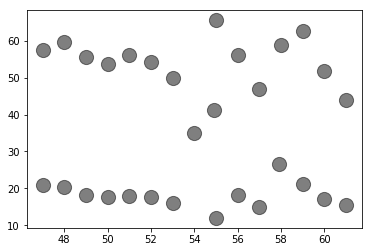

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30)
X=trainData4.values
#X=X.drop(['datetime','timestamp','geohash6'],axis=1).values
testX=testData4.values
#testX=testX.drop(['datetime','timestamp','geohash6'],axis=1).values

kmeans.fit(X)
y_kmeans = kmeans.predict(trainX)
#plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
len(y_kmeans)

In [253]:
!pip install catboost 

     |████████████████████████████████| 61.1MB 613kB/s 


In [0]:

#trainDataX

#display(SVG(graph.pipe(format='svg')))
#display.display(SVG(str_tree)
#trainData1,trainLabel1,testData1=splitData1(randDataSet, dataset)
#trainData2,trainLabel2,testData2=splitData2(randDataSet, dataset)
#trainData3,trainLabel3,testData3=splitData3(randDataSet, dataset)
#trainData4,trainLabel4,testData4=splitData4(randDataSet, dataset)

#for row in randDataSet.itertuples():
#randDataSet['neighborPrevDemand']=dataset.loc[randDataSet['geohash6']].mean()
#print('length of 1st:',len(trainData1)+len(testData1),',2th:',len(trainData2)+len(testData2),',3th:',len(trainData3)+len(testData3),' 4th ',len(trainData4)+len(testData4))
#trainData4
#preds
# TODO write method to find geohash with highest error and see why, how to improve

#model_fit = arima_model.fit(trainData.demand, suppress_warnings=True)
#trainData.demand

array([0.06192209, 0.05783723, 0.0600192 , 0.05783723, 0.06192209])

In [0]:
#predictedRandForestRegressor1['qp03zx']
randGeoHash='qp02yu'
randDataSet=dataset.loc[dataset.geohash6==randGeoHash]

testData=randDataSet[-5:]
trainData=randDataSet.loc[(dataset.day>=testData.iloc[0].day-14) & (dataset.x<testData.iloc[0].x)]
#trainData.plot(x='x',y='demand')
#testData.plot(x='x',y='demand')

#predictInvalidPreds('qp08fu',predictedArima2)
#predictedArima2
#np.isfinite(predictedArima1['qp03zx'])


#HeatMap with time to see if any ideas to improve model

In [0]:
#https://alysivji.github.io/getting-started-with-folium.html
# max value seem like 999 even though manual say 0-1
mapData=[]
#time_in_x_slider = 7 #@param {type:"slider", min:0, max:100, step:1}

for x in range(5850,dataset.x.max()): # max seem like 30
  #range(0, dataset.x.max())
  # skip so that faster but will missed some logic
  #if(x % 500 != 0):
  #   continue
  subData=[]
  for row in dataset.loc[dataset['x']==x].itertuples():
    gh6decoded=geohash.decode(getattr(row,'geohash6'))      
    subData.append([gh6decoded[0],gh6decoded[1],getattr(row,'demand')*10])
  mapData.append(subData)
        
m=folium.Map([mapData[0][0][0],mapData[0][0][1]], zoom_start=10)
m.add_child(plugins.HeatMapWithTime(mapData, radius=10, auto_play=True)) # seem like cannot change speed or loop
m.add_child(folium.LatLngPopup())



In [209]:
#https://stackoverflow.com/questions/3810865/matplotlib-unknown-projection-3d-error
visData1=dataset[dataset.geohash6==np.random.choice(dataset.geohash6.unique(),2)[0]]
trainDataa,trainLabela,testDataa=splitData10(visData1, dataset)
visData2=dataset[dataset.geohash6==np.random.choice(dataset.geohash6.unique(),2)[0]]
trainDatab,trainLabelb,testDatab=splitData10(visData2, dataset)
trainDataa,trainLabela,testDataa=splitData10(dataset[dataset.geohash6=='qp0d4m'],dataset)

#a=pd.DataFrame()
#testDataa
#trainDataa['demand']=trainLabel6a
#trainDatab['demand']=trainLabel6b
#a['6a']=trainDataa.groupby('timestampX').describe()
#a['6b']=trainDatab.groupby('timestampX').describe()


#a
#randGeoHashes=
#fig,ax1 = plt.subplots(figsize=(4,4))
#ax1.scatter(trainData6a['timestampX'], trainLabel6a)
#fig,ax2 = plt.subplots(figsize=(4,4))
#ax2.scatter(trainData6b['timestampX'], trainLabel6b)
#plt.show()

,day,timestampX,dayOfWeek,x,demandEmptyTimeCount
3692545,42,49,0,3985,0.0


,day,timestampX,dayOfWeek,x,demand,demandEmptyTimeCount
1052018,47.0,0.0,5.0,4416,0.094914,0.0
1947725,47.0,1.0,5.0,4417,0.070080,1.0
419870,47.0,2.0,5.0,4418,0.097505,0.0
3860768,47.0,3.0,5.0,4419,0.105218,0.0
2480279,47.0,4.0,5.0,4420,0.135887,0.0
3590441,47.0,5.0,5.0,4421,0.088575,0.0
966622,47.0,6.0,5.0,4422,0.133793,0.0
2269011,47.0,7.0,5.0,4423,0.132499,0.0
2417416,47.0,8.0,5.0,4424,0.156030,0.0
1403063,47.0,9.0,5.0,4425,0.139918,0.0


# Model Performance
### "Your model can use features of up to 14 consecutive days from the test dataset, ending at timestamp T and predict T+1 to T+5."
### "Geohash coverage: You may assume that the set of geohashes are the same in training dataset and test dataset. The original geohashes are anonymised, but you may assume that adjacency is maintained between the geohashes.""
### "Submissions will be evaluated by RMSE (root mean squared error) averaged over all geohash6, 15-minute-bucket pairs."